In [41]:
import pandas as pd
import pubchempy as pcp
import seaborn as sns
import rdkit
import torch
import vina
import meeko
import pexpect
import pickle
import numpy as np
from scipy.stats import norm
from typing import Optional, Union, List
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.domain_reduction import DomainTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.target_space import TargetSpace
import sys
import json
from contextlib import redirect_stdout

from selectivebayes.interfaces import vaeinterface,vinainterface
from selectivebayes.transformers import SequentialDomainReductionTransformer,SimpleDomainReduction

def visualise(molecules,labels, size,row):
    img = rdkit.Chem.Draw.MolsToGridImage([rdkit.Chem.MolFromSmiles(mol) for mol in molecules],subImgSize=(size,size),molsPerRow=row,legends=labels)
    return img

latent_size=56

In [35]:
knowndrugs = {"Gilteritinib":r"CCc1nc(C(=O)N)c(Nc2ccc(N3CCC(CC3)N4CCN(C)CC4)c(OC)c2)nc1NC5CCOCC5", 
              "Quizartinib":r"CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)c3cn4c5ccc(cc5sc4n3)OCCN6CCOCC6", 
              "Crenolanib":r"O(c5cc4ncn(c1nc3c(cc1)cccc3N2CCC(N)CC2)c4cc5)CC6(COC6)C",
              "Tandutinib":r"CC(C)OC1=CC=C(C=C1)NC(=O)N2CCN(CC2)C3=NC=NC4=CC(=C(C=C43)OC)OCCCN5CCCCC5",
              "Sorafenib":r"CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl",
              "Sunitinib":r"CCN(CC)CCNC(=O)c1c(c([nH]c1C)/C=C\2/c3cc(ccc3NC2=O)F)C",
              "Lestaurtinib":r"C[C@@]12[C@](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)(CO)O",
              "Midostaurin":r"C[C@@]12[C@@H]([C@@H](C[C@@H](O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)N(C)C(=O)C9=CC=CC=C9)OC",
              "Ponatinib":r"Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C"
              }

fps = {x:rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(knowndrugs[x])) for x in knowndrugs}
def simsearch(molecule):
    if molecule=="failed":
        return 0,0
    molfing = rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(molecule))
    highestsim = 0
    bestmolec = ""
    for fp in fps:
        currsim = rdkit.DataStructs.FingerprintSimilarity(fps[fp],molfing)
        if currsim>highestsim:
            highestsim=currsim
            bestmolec = fp
    return highestsim,bestmolec

In [ ]:
pbounds = {f"f{i}": (-3,3) for i in range(56)}
bounds_transformer = SequentialDomainReductionTransformer(prob=0.5)
optimizer = BayesianOptimization(f=np.square,pbounds=pbounds,verbose=0,bounds_transformer=bounds_transformer)
load_logs(optimizer, logs=["./predictions/minwin05.json"])
seenpreds = set()
predplot = []
x=[]

for i,pred in enumerate(optimizer.res):
    if pred["target"] not in seenpreds:
        predplot.append(pred["target"])
        x.append(i)
        seenpreds.add(pred["target"])
#ax=sns.regplot(x=x,y=predplot)
#ax.set(xlabel="Iteration",ylabel="Objective")
pred_df = pd.DataFrame(data={"pred": predplot,"x": x})
#pred_df["rolling"]=pred_df["pred"].rolling(50,min_periods=5 ,center=True).mean()
pred_df["rolling"]=pred_df["pred"].ewm(alpha=0.05).mean()
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style("white")
ax=sns.scatterplot(data=pred_df,x="x",y="pred")
ax=sns.lineplot(data=pred_df,x="x",y="rolling",color="red")
ax.set(xlabel="Iteration",ylabel="Objective")

(0.3786242183058556, 'Midostaurin')
(0.44184752365052865, 'Midostaurin')
(0.39545454545454545, 'Midostaurin')
(0.25836575875486384, 'Ponatinib')
(0.4248733821046708, 'Midostaurin')
(0.3582089552238806, 'Midostaurin')
(0.37471395881006864, 'Midostaurin')
(0.4031710079275198, 'Midostaurin')
(0.3786242183058556, 'Midostaurin')
(0.30358191426893716, 'Midostaurin')
(0.32966396292004635, 'Midostaurin')
(0.29467455621301775, 'Midostaurin')
(0.2592313489073097, 'Sunitinib')
(0.31010452961672474, 'Midostaurin')
(0.3055235903337169, 'Midostaurin')
(0.3274942878903275, 'Ponatinib')
(0.34795152914021926, 'Midostaurin')
(0.3872053872053872, 'Midostaurin')
(0.24798061389337642, 'Ponatinib')
(0.363319791062101, 'Midostaurin')


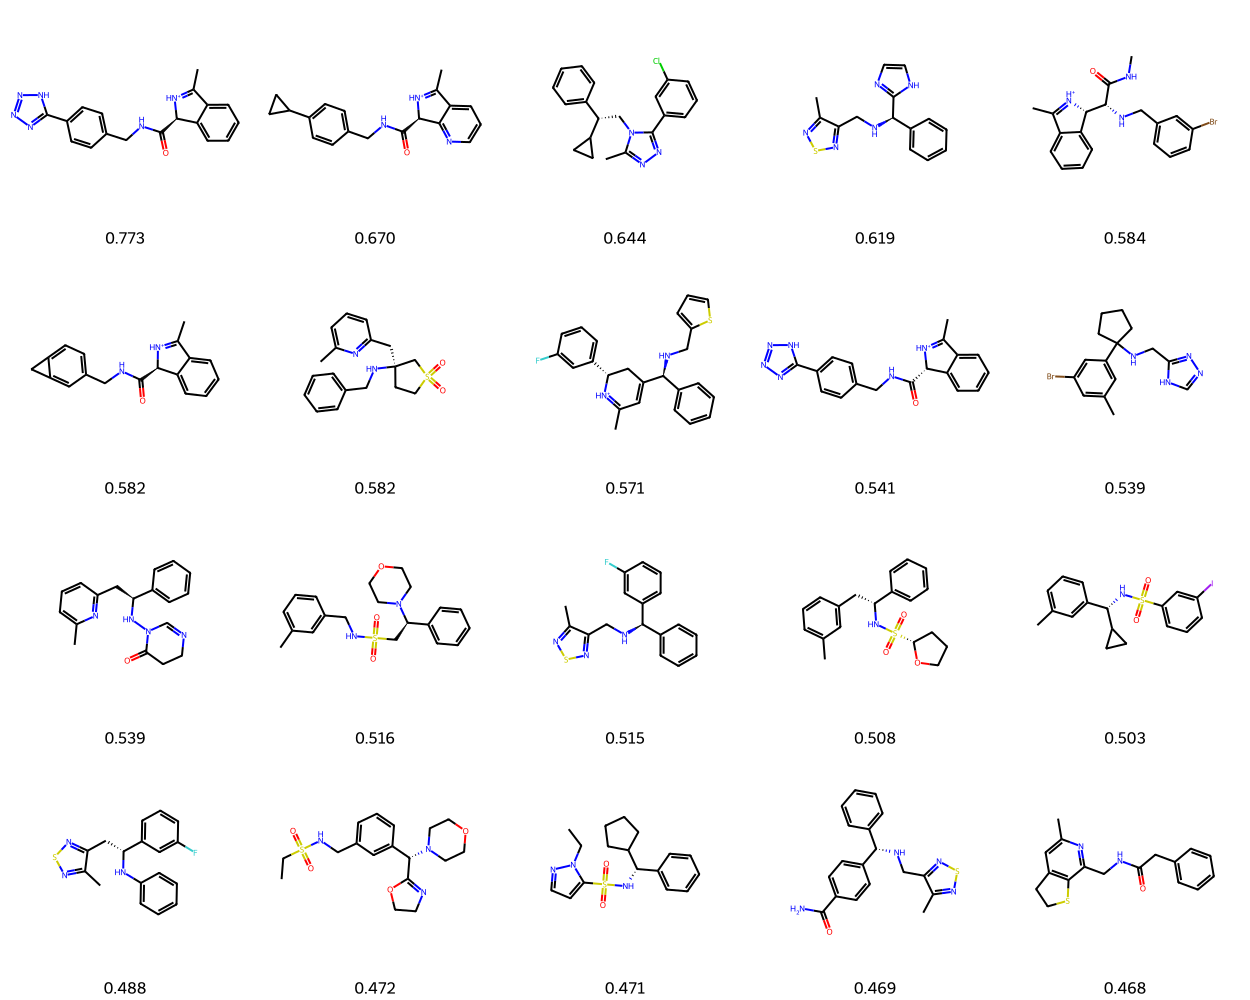

In [40]:
pred200 = "./predictions/200pred_list_prob03_doubleexhaustforbest.pk1"
pred500new = "./predictions/500pred_list_newdomainreduction.pk1"
pred200new = "./predictions/200pred_list2_newdomainreduction.pk1"

data = pickle.load(open(pred200new,"rb"))
seendata = set()
for molecule in data:
    if molecule[0] in seendata:
        molecule[1]=0
    seendata.add(molecule[0])
data = sorted(data,key=lambda x:x[1],reverse=True)
nummolecs = 20
topmolecules = [molecule[0] for molecule in data[:nummolecs]]
topscores = ["%.3f"%round(molecule[1],3) for molecule in data[:nummolecs]]
for i in topmolecules:
    print(simsearch(i))
#visualise(topmolecules,topscores, size=250,row=5)


In [ ]:
data2 = pickle.load(open("./predictions/500pred_list_newdomainreduction.pk1","rb"))
seendata2 = set()
for molecule in data2:
    if molecule[0] in seendata2:
        molecule[1]=0
    seendata2.add(molecule[0])
data2 = sorted(data2,key=lambda x:x[1],reverse=True)
topmolecules2 = [molecule[0] for molecule in data2[:nummolecs]]

molfing=[]
molecs=[]
for molec in topmolecules:
    molecs.append(molec)
    molfing.append(rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(molec)))
molfing2=[]
molecs2=[]
for molec in topmolecules2:
    molecs2.append(molec)
    molfing2.append(rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(molec)))

for j,molec2 in enumerate(molfing2):
    scores = rdkit.Chem.DataStructs.BulkTanimotoSimilarity(molec2, molfing)
    for i, score in enumerate(scores):
        if score >= 0.4:
            target_id = molecs[i]
            print(f"{molecs2[j]}\t{target_id}\t{score:.3f}")

In [29]:
molecules = []
for molec in topmolecules:
    comps = pcp.get_compounds(molec,"smiles", searchtype='fastsimilarity_3d', listkey_count=1)
    print(comps[0].isomeric_smiles)
    molecules.append(comps[0].isomeric_smiles)
visualise([molecules],None,250,5)

IndexError: list index out of range